In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import dgl
import networkx as nx
import torch
import torch.nn as nn

from sklearn.metrics.pairwise import cosine_distances


import utils
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.baselines_archs import MLP, GAT
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows, Dual_GFGCN, NV_GFGCN, GCNN

# SEED = 0
SEED = 15
PATH = 'results/try_datasets'
SAVE = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [2]:
def print_full_results(accs, ellapsed_time, datasets, exps):
    mean_accs = accs.mean(axis=2)
    med_accs = np.median(accs, axis=2)
    std_accs = accs.std(axis=2)
    mean_t = ellapsed_time.mean(axis=2)

    for i, dataset_name in enumerate(datasets):
        graph = getattr(dgl.data, dataset_name)(verbose=False)[0]
        edge_hom = dgl.edge_homophily(graph, graph.ndata['label'])

        print(f'{dataset_name} (homophily ratio: {edge_hom:.3f})')
        for j, exp in enumerate(exps):
            print(f'\t- {exp["leg"]}:\tmean: {mean_accs[j,i]:.3f} - std: {std_accs[j,i]:.4f} - med: {med_accs[j,i]:.3f} - time: {mean_t[j,i]:.2f} mins')
        
        print()

def summary_table(accs, datasets, layers, exps, median=False):
    mean_accs = accs.mean(axis=3)
    results_dataset = {}
    index_name = [exp['leg'] for exp in exps]
    cols = [f"L={l}" for l in layers]

    for d, dataset_name in enumerate(datasets):
        graph = getattr(dgl.data, dataset_name)(verbose=False)[0]
        #edge_hom = dgl.edge_homophily(graph, graph.ndata['label'])
        results_dataset[dataset_name] = DataFrame(mean_accs[:,d,:], columns=cols, index=index_name)

    return results_dataset

In [3]:
DATASETS = ['TexasDataset',  'WisconsinDataset', 'CornellDataset', 'ChameleonDataset', 'CoraGraphDataset', 'CiteseerGraphDataset']
DATASETS = ['TexasDataset', 'CornellDataset', 'CoraGraphDataset']
layers = [2,3,4,5,6]

In [4]:
def mad_metric(H, M=None):
    # Pairwise distances
    D = cosine_distances(H,H)

    # Masking
    if M is None:
        M = np.ones(D.shape) - np.eye(D.shape[0])
    D_tgt = D * M

    Dbar = np.sum(D_tgt, 1) / np.where(np.isclose(np.count_nonzero(D_tgt, 1), 0), 1, np.count_nonzero(D_tgt, 1))

    Mad = np.sum(Dbar) / np.count_nonzero(Dbar)

    return Mad

In [5]:
N_RUNS = 5
ACT = nn.ReLU()  # nn.ReLU()
#LAST_ACT = nn.Softmax(dim=1)
LAST_ACT = nn.Identity()
LOSS_FN = nn.CrossEntropyLoss() #nn.NLLLoss()

EXPS = [{'model': 'Kipf', 'norm': 'both', 'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': .5,
          'L': 2, 'hid_dim': 64, 'leg': 'Kipf-normA'},
        {'model': 'Kipf', 'norm': 'none', 'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': .5,
          'L': 2, 'hid_dim': 64, 'leg': 'Kipf-A'},

        # {'model': 'MLP', 'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': .5,
        #   'hid_dim': 16, 'leg': 'MLP'},
        {'model': 'MLP', 'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0.,
          'hid_dim': 16, 'L': 3, 'leg': 'MLP'},

        {'model': 'GAT', 'heads': 2, 'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0,
          'hid_dim': 16, 'leg': 'GAT'},
          

        # {'model': 'GFGCN', 'epochs': 200, 'e_h': 10, 'e_W': 10, 'lr': .01, 'wd': .001, 'drop': .5,
        #  'hid_dim': 50, 'L': 2, 'K': 3, 'h0': 1, 'norm': True, 'last_act': nn.LogSoftmax(dim=1), 'leg': 'A-GCN-normA'},

        {'model': 'GFGCN', 'epochs': 200, 'e_h': 25, 'e_W': 25, 'lr': .005, 'wd': .001, 'drop': .5,
         'hid_dim': 64,'L': 2, 'K': 3, 'h0': 1, 'norm': True, 'last_act': nn.LogSoftmax(dim=1), 'leg': 'A-GCN'},

        # {'model': 'GFGCN', 'epochs': 200, 'e_h': 25, 'e_W': 25, 'lr': .005, 'wd': .001, 'drop': .5,
        #  'hid_dim': 64,'L': 2, 'K': 3, 'h0': 1, 'norm': False, 'leg': 'A-GCN-v2'},

        {'model': 'H-GFGCN', 'epochs': 200, 'e_h': 5, 'e_W': 25, 'lr': .005, 'wd': 5e-4, 'drop': .5,
         'hid_dim': 32,'L': 3, 'K': 2, 'norm': True, 'leg': 'H-GCN-normH'},

        # {'model': 'Dual-GFGCN', 'epochs': 200, 'e_h': 50, 'e_W': 25, 'lr': .005, 'wd': .001, 'drop': .25,
        #  'bias': True, 'alpha': None, 'hid_dim': 32,'L': 3, 'K': 2, 'h0': 1, 'norm': False, 'leg': 'Dual-GFCN-alpha'},

        {'model': 'Dual-GFGCN', 'epochs': 200, 'e_h': 10, 'e_W': 10, 'lr': .01, 'wd': .005, 'drop': .5,
         'bias': True, 'alpha': None, 'hid_dim': 32,'L': 3, 'K': 2, 'h0': 1, 'norm': True,
         'act': nn.ReLU(), 'last_act': nn.LogSoftmax(dim=1), 'leg': 'Dual-GFCN-alpha-n'},

        # {'model': 'Dual-GFGCN', 'epochs': 200, 'e_h': 25, 'e_W': 25, 'lr': .005, 'wd': .005, 'drop': .25,
        #   'bias': False, 'alpha': .8, 'hid_dim': 32,'L': 3, 'K': 2, 'h0': 1, 'norm': False, 'leg': 'Dual-GFCN'},

        # {'model': 'Dual-GFGCN', 'epochs': 200, 'e_h': 25, 'e_W': 25, 'lr': .005, 'wd': .005, 'drop': .25,
        #   'bias': True, 'alpha': .8, 'hid_dim': 32,'L': 3, 'K': 2, 'h0': .1, 'norm': True, 'leg': 'Dual-GFCN-n'},

        # {'model': 'H-GFGCN', 'epochs': 200, 'e_h': 25, 'e_W': 25, 'lr': .005, 'wd': .001, 'drop': .25,
        #  'hid_dim': 32,'L': 2, 'K': 3, 'norm': False, 'leg': 'H-GCN'},
         

        {'model': 'noh-GFGCN', 'epochs': 500, 'lr': .001, 'wd': .01, 'drop': .0,
         'hid_dim': 64, 'L': 2, 'K': 3, 'norm': True, 'act': nn.Tanh(), 'last_act': nn.Identity(), 'leg': 'W-GCN'},
        # {'model': 'noh-GFGCN', 'epochs': 500, 'lr': .005, 'wd': .01, 'drop': .25,
        #  'hid_dim': 32, 'L': 2, 'K': 2, 'norm': False, 'leg': 'W-GCN'}
]


In [7]:
best_accs = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
accs_best_val = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
accs_best_val2 = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
ellapsed_times = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
mad_all = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
mad_label = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))
mad_diff_label = np.zeros((len(EXPS), len(DATASETS), len(layers), N_RUNS))

for j, dataset in enumerate(DATASETS):
    print(dataset)

    for l, layer in enumerate(layers):

        print(f"Layers {layer}")

        for i in range(N_RUNS):
            print(f'{i}:', end=' ')
            
            A, feat, labels, n_class, masks = utils.get_data_dgl(dataset, dev=device, idx=i%10)
            N = A.shape[0]
            in_dim = feat.shape[1]
            out_dim = n_class

            M_label = np.zeros((N,N))
            for n1 in range(N):
                for n2 in range(N):
                    M_label[n1,n2] = (labels[n1] == labels[n2]).cpu().numpy().astype(float)
            M_diff_label = 1.-M_label
            M_label = M_label - np.eye(N)
            
            for k, exp in enumerate(EXPS):
                t_i = time.time()
                if exp['model'] == 'Kipf':
                    arch = GCNN(in_dim, exp['hid_dim'], out_dim, layer, act=ACT, last_act=LAST_ACT,
                                dropout=exp['drop'])
                    if exp['norm']:
                        S = torch.Tensor(normalize_gso(A.copy(), 'both')).to(device)
                    else:
                        S = torch.Tensor(A.copy()).to(device)

                elif exp['model'] == 'MLP':
                    arch = MLP(in_dim,  exp['hid_dim'], out_dim, exp['L'], act=ACT, last_act=LAST_ACT, dropout=exp['drop'])
    
                elif exp['model'] == 'GAT':
                    gat_params = {'attn_drop': exp['drop']}
                    arch = GAT(in_dim,  exp['hid_dim'], out_dim, exp['heads'], gat_params, act=ACT, last_act=LAST_ACT)
                    S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)

                elif exp['model'] == 'GFGCN':
                    arch = GFGCN(in_dim, exp['hid_dim'], out_dim, layer, exp['K'], act=ACT, last_act=exp['last_act'],
                            dropout=exp['drop'], diff_layer=GFGCNLayer, init_h0=exp['h0'])
                    if exp['norm']:
                        S = torch.Tensor(normalize_gso(A.copy(), 'both')).to(device)
                    else:
                        S = torch.Tensor(A.copy()).to(device)

                elif exp['model'] == 'H-GFGCN':
                    arch = GFGCN_Spows(in_dim, exp['hid_dim'], out_dim, layer, exp['K'], act=ACT, last_act=LAST_ACT,
                                    dropout=exp['drop'], norm=exp['norm'], dev=device)
                    S = torch.Tensor(A.copy()).to(device)

                elif exp['model'] == 'NV-GFGCN':
                    arch = NV_GFGCN(in_dim, exp['hid_dim'], out_dim, layer, exp['K'], N, act=ACT,
                                    last_act=LAST_ACT, f_type=exp['type'], dropout=exp['drop'])
                    S = torch.Tensor(A.copy()).to(device)
                
                elif exp['model'] == 'noh-GFGCN':
                    arch = GFGCN(in_dim, exp['hid_dim'], out_dim, layer, exp['K'], act=exp['act'], last_act=exp['last_act'],
                                dropout=exp['drop'], diff_layer=GFGCN_noh_Layer)
                    if exp['norm']:
                        S = torch.Tensor(normalize_gso(A.copy(), 'both')).to(device)
                    else:
                        S = torch.Tensor(A.copy()).to(device)

                elif exp['model'] == 'Dual-GFGCN':
                    arch = Dual_GFGCN(in_dim, exp['hid_dim'], out_dim, layer, exp['K'], act=ACT, alpha=exp['alpha'],
                                    last_act=LAST_ACT, dropout=exp['drop'], init_h0=exp['h0'], bias=exp['bias'])
                    if exp['norm']:
                        S = torch.Tensor(normalize_gso(A.copy(), 'both', add_id=False)).to(device)
                    else:
                        S = torch.Tensor(A.copy()).to(device)
                else:
                    raise Exception(f'ERROR: unknown architecture {exp["model"]}')

                if exp['model'] in ['Kipf', 'MLP', 'GAT', 'noh-GFGCN']:
                    model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
                    loss, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])
                else:
                    model = GF_NodeClassModel(arch, S, exp['K'], masks, LOSS_FN, device=device)
                    loss, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                                            epochs_h=exp['e_h'], epochs_W=exp['e_W'])
                
                if exp['model'] == "MLP":
                    embs = model.arch(feat).detach().cpu().numpy()
                else:
                    embs = model.arch(model.S, feat).detach().cpu().numpy()
                
                mad_all[k,j,l,i] = mad_metric(embs)
                mad_label[k,j,l,i] = mad_metric(embs, M=M_label)
                mad_diff_label[k,j,l,i] = mad_metric(embs, M=M_diff_label)

                ellapsed_t = (time.time()-t_i)/60
                
                best_accs[k,j,l,i] = np.max(acc["test"])
                accs_best_val[k,j,l,i] = model.test(feat, model.S, labels, masks['test'])
                accs_best_val2[k,j,l,i] = acc["test"][np.argmax(acc["val"])]

                ellapsed_times[k,j,l,i] = ellapsed_t

                print(f'{accs_best_val[k,j,l,i]:.3f} ({best_accs[k,j,l,i]:.3f})', end=' - ')
            print()
        print()
    print()

TexasDataset
Layers 2
0: 0.405 (0.676) - 0.486 (0.595) - 0.811 (0.811) - 0.622 (0.676) - 0.811 (0.811) - 0.838 (0.838) - 0.838 (0.892) - 0.649 (0.649) - 
1: 0.568 (0.622) - 0.595 (0.649) - 0.757 (0.865) - 0.595 (0.649) - 0.919 (0.919) - 0.946 (0.973) - 0.919 (0.946) - 0.595 (0.622) - 
2: 0.351 (0.514) - 0.405 (0.486) - 0.757 (0.784) - 0.459 (0.541) - 0.757 (0.757) - 0.838 (0.892) - 0.757 (0.865) - 0.514 (0.568) - 
3: 0.486 (0.595) - 0.486 (0.649) - 0.865 (0.865) - 0.622 (0.622) - 0.865 (0.946) - 0.865 (0.973) - 0.838 (0.919) - 0.622 (0.622) - 
4: 0.432 (0.541) - 0.514 (0.595) - 0.703 (0.784) - 0.568 (0.568) - 0.784 (0.811) - 0.892 (0.919) - 0.946 (0.946) - 0.595 (0.649) - 

Layers 3
0: 0.541 (0.703) - 0.568 (0.649) - 0.838 (0.838) - 0.541 (0.649) - 0.378 (0.459) - 0.649 (0.730) - 0.838 (0.865) - 0.622 (0.649) - 
1: 0.568 (0.595) - 0.568 (0.595) - 0.784 (0.838) - 0.622 (0.622) - 0.541 (0.649) - 0.595 (0.865) - 0.595 (0.865) - 0.595 (0.622) - 
2: 0.351 (0.514) - 0.378 (0.486) - 0.757 (0.

In [8]:
table_acc1 = summary_table(best_accs, DATASETS, layers, EXPS)
table_acc_val1 = summary_table(accs_best_val, DATASETS, layers, EXPS)
table_acc_val1b = summary_table(accs_best_val2, DATASETS, layers, EXPS)

In [9]:
table_acc_val1b['TexasDataset']

,L=2,L=3,L=4,L=5,L=6
Kipf-normA,0.491892,0.551351,0.556757,0.572973,0.583784
Kipf-A,0.508108,0.562162,0.578378,0.556757,0.583784
MLP,0.745946,0.789189,0.767568,0.789189,0.805405
GAT,0.572973,0.545946,0.545946,0.578378,0.567568
A-GCN,0.821622,0.475676,0.524324,0.583784,0.589189
H-GCN-normH,0.832432,0.691892,0.578378,0.562162,0.610811
Dual-GFCN-alpha-n,0.843243,0.718919,0.643243,0.589189,0.589189
W-GCN,0.594595,0.583784,0.583784,0.594595,0.567568


In [35]:
table_acc_val1b['CoraGraphDataset']

,L=2,L=3,L=4,L=5,L=6
Kipf-normA,0.8164,0.8104,0.7982,0.7982,0.7938
Kipf-A,0.8194,0.8188,0.8008,0.7820,0.7868
MLP,0.4932,0.5002,0.5300,0.4968,0.5238
GAT,0.7952,0.7880,0.7978,0.7846,0.7890
A-GCN,0.7998,0.7962,0.7862,0.7862,0.7682
H-GCN-normH,0.8106,0.8012,0.7914,0.7840,0.7660
Dual-GFCN-alpha-n,0.7840,0.8016,0.7980,0.7918,0.7854
W-GCN,0.7886,0.7768,0.1618,0.1474,0.1516


In [10]:
table_mad_all = summary_table(mad_all, DATASETS, layers, EXPS)
table_mad_label = summary_table(mad_label, DATASETS, layers, EXPS)
table_mad_diff_label = summary_table(mad_diff_label, DATASETS, layers, EXPS)

In [11]:
table_mad_all['TexasDataset']

,L=2,L=3,L=4,L=5,L=6
Kipf-normA,0.357178,0.266473,0.182997,0.074344,0.018518
Kipf-A,0.388501,0.259240,0.151776,0.089397,0.020198
MLP,0.451497,0.439268,0.429873,0.392372,0.391533
GAT,0.074876,0.100727,0.128424,0.141933,0.069792
A-GCN,0.173704,0.120942,0.038919,0.009960,0.006469
H-GCN-normH,0.722872,0.271184,0.104970,0.016900,0.008381
Dual-GFCN-alpha-n,0.744126,0.547793,0.263026,0.101453,0.110324
W-GCN,0.451498,0.168925,0.128559,0.210866,0.214381


In [12]:
table_mad_all['CornellDataset']

,L=2,L=3,L=4,L=5,L=6
Kipf-normA,0.533188,0.522648,0.233524,0.147519,0.026910
Kipf-A,0.594812,0.503337,0.253960,0.171861,0.052233
MLP,0.594324,0.659204,0.718083,0.619749,0.737388
GAT,0.378960,0.319342,0.364317,0.375371,0.257814
A-GCN,0.198766,0.130948,0.050475,0.014977,0.010902
H-GCN-normH,0.649851,0.336140,0.118781,0.126294,0.026727
Dual-GFCN-alpha-n,0.806329,0.743529,0.389727,0.324924,0.365723
W-GCN,0.631559,0.182129,0.081968,0.078434,0.167915


In [13]:
table_mad_all['CoraGraphDataset']

,L=2,L=3,L=4,L=5,L=6
Kipf-normA,0.914260,0.871318,0.785264,0.824931,0.788115
Kipf-A,0.911660,0.893473,0.806525,0.814062,0.800336
MLP,0.790069,0.786807,0.795693,0.779097,0.775956
GAT,0.823596,0.782270,0.839445,0.778750,0.822225
A-GCN,0.172741,0.190552,0.170270,0.161789,0.195911
H-GCN-normH,0.909398,0.889355,0.853427,0.842140,0.822899
Dual-GFCN-alpha-n,0.937945,0.884846,0.886436,0.860466,0.809316
W-GCN,0.923472,0.944565,0.820637,0.809396,0.831852


In [42]:
def plot_mads(tables, dataset):
    
    N = len(tables)
    dfs = [tables[i][dataset] for i in range(N)]
    
    f, ax = plt.subplots(1,N,figsize=(20,8))
    
    for i, df in enumerate(dfs):
        sns.heatmap(df.values, ax=ax[i], annot=True)
        ax[i].set_xticks(np.arange(5) + 0.5)
        ax[i].set_xticklabels(np.arange(2,7))
        ax[i].set_yticks(np.arange(len(df)) + 0.5)
        ax[i].set_yticklabels(df.index, rotation=45)
    
    #f.subplots_adjust(right=0.8)
    #cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    #f.colorbar(im, cax=cbar_ax)
    
    f.suptitle(dataset, fontsize=24)

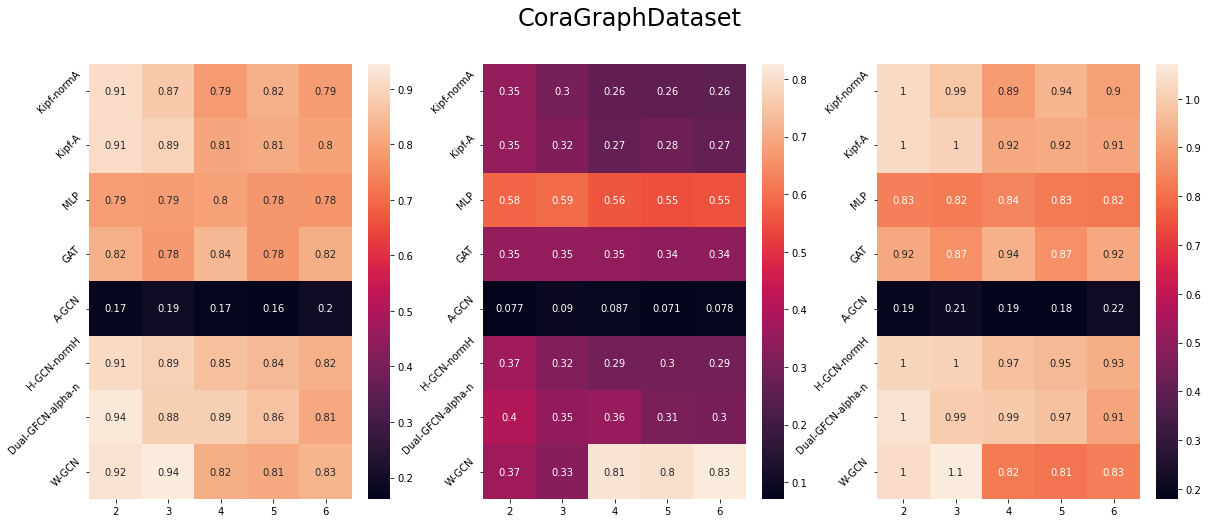

In [43]:
plot_mads([table_mad_all, table_mad_label, table_mad_diff_label], 'CoraGraphDataset')

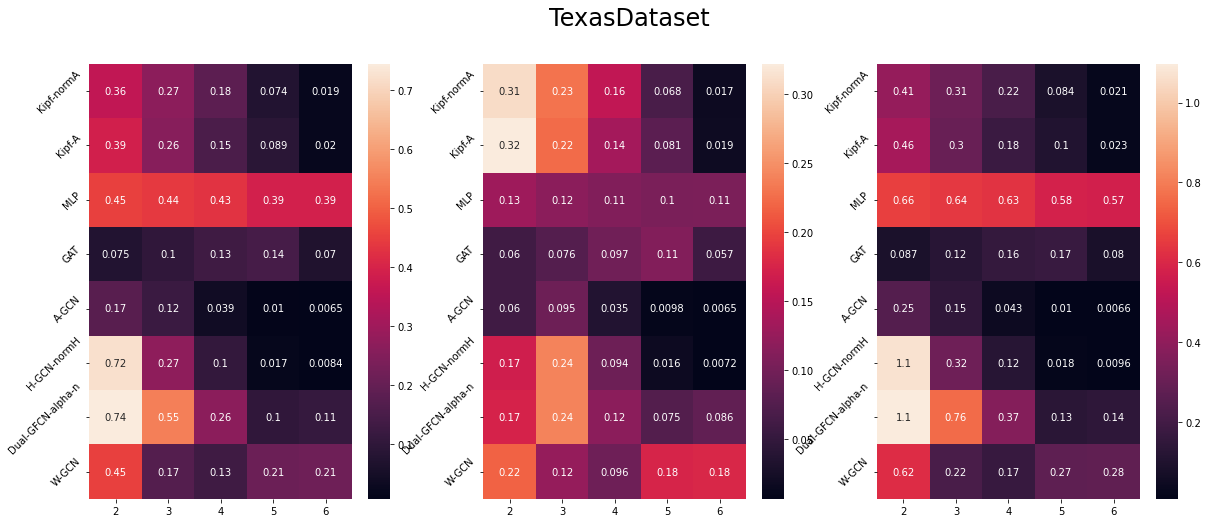

In [44]:
plot_mads([table_mad_all, table_mad_label, table_mad_diff_label], 'TexasDataset')

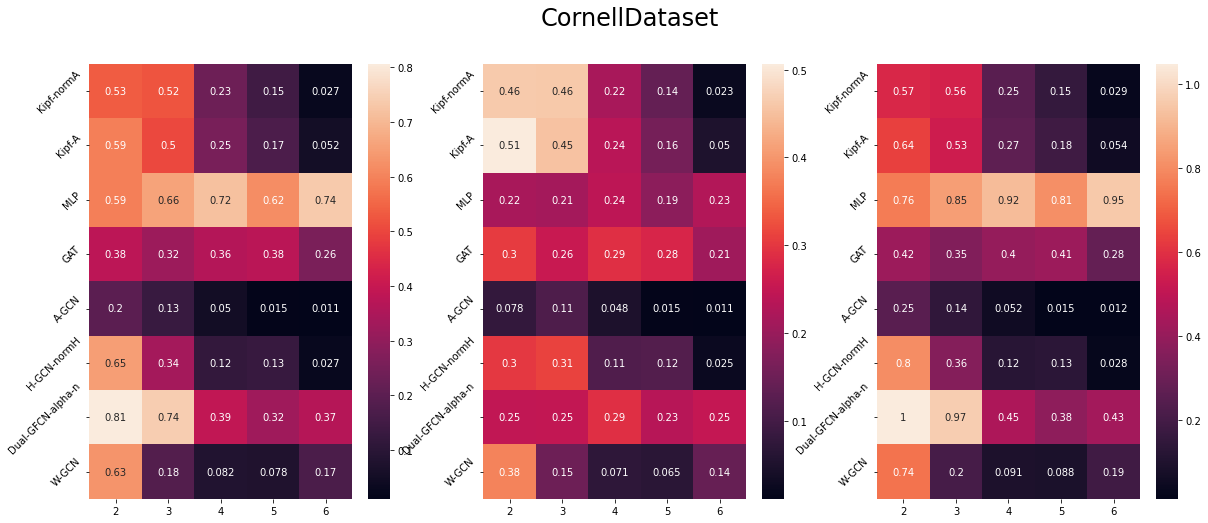

In [46]:
plot_mads([table_mad_all, table_mad_label, table_mad_diff_label], 'CornellDataset')

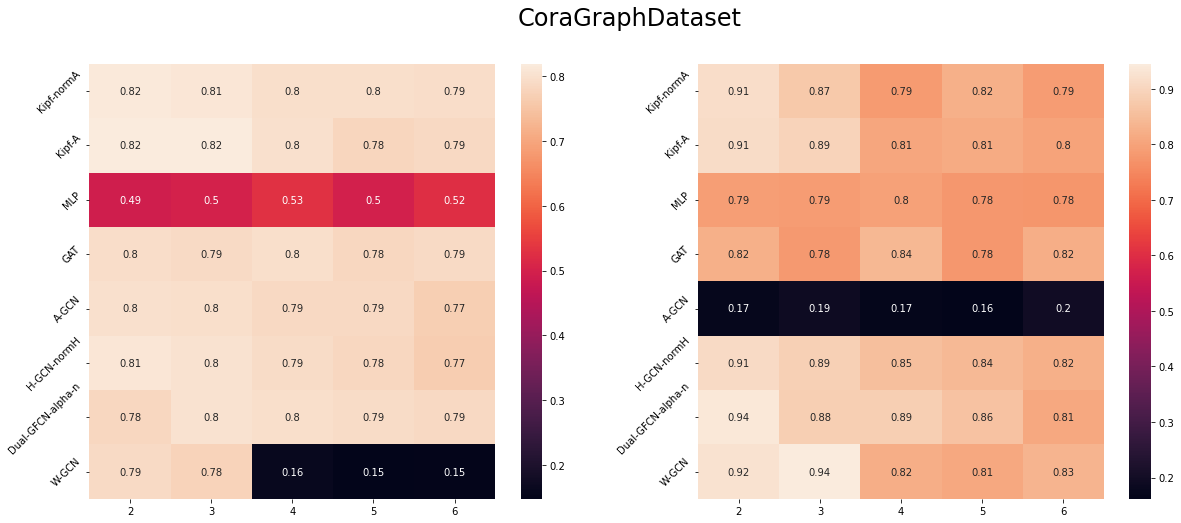

In [48]:
plot_mads([table_acc_val1b, table_mad_all], "CoraGraphDataset")

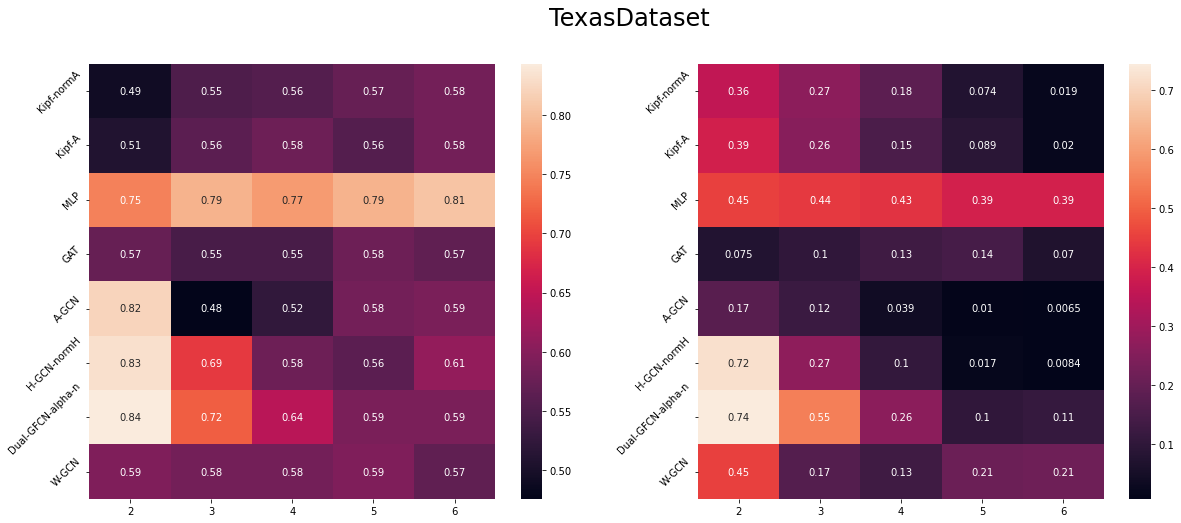

In [50]:
plot_mads([table_acc_val1b, table_mad_all], "TexasDataset")

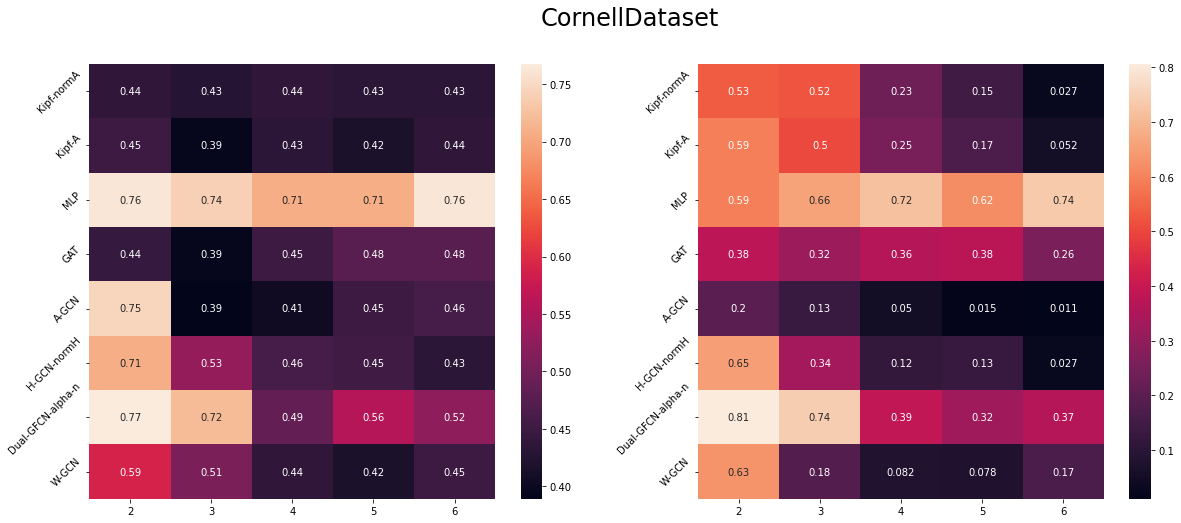

In [51]:
plot_mads([table_acc_val1b, table_mad_all], "CornellDataset")